In [1]:
import requests
import json
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
BALSHT = requests.get('https://www.alphavantage.co/query?function=BALANCE_SHEET&symbol=AAPL&apikey=BNM3OK9KHBBVD3YZ') #api request for balance sheet for AAPL
INCSTAT = requests.get('https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol=AAPL&apikey=BNM3OK9KHBBVD3YZ') #api request for income statement for AAPL
TSERIES = requests.get('https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=aapl&outputsize=full&apikey=BNM3OK9KHBBVD3YZ') 

bsolddf = pd.read_excel("AAPL BAL SHEET.xls")

isolddf = pd.read_excel("AAPL INCOME SHEET.xls")

interest = pd.read_csv('FEDFUNDS.csv',index_col=0)

In [3]:
bsdata = BALSHT.text
bsparsed = json.loads(bsdata)
bsquartdata = bsparsed['quarterlyReports']
bsquartdf = pd.DataFrame.from_dict(bsquartdata)

isdata = INCSTAT.text
isparsed = json.loads(isdata)
isquartdata = isparsed['quarterlyReports']
isquartdf = pd.DataFrame.from_dict(isquartdata)

data = TSERIES.text
parsed = json.loads(data)
tsdata = parsed['Time Series (Daily)']
tsda = pd.DataFrame.from_dict(tsdata, orient='index')
tsda_new=tsda.loc[:'2009-01-02',]

In [4]:
#price variable
price=tsda_new.drop(['1. open','2. high','3. low','4. close','6. volume','7. dividend amount','8. split coefficient'],1)
price.rename(columns={"5. adjusted close":"price"},inplace=True)
price.price = pd.to_numeric(price.price)
price.index = pd.to_datetime(price.index)
price.index=price.index.map(dt.datetime.toordinal)

In [5]:
#extracting dividends from tsda_new
dividend=tsda_new.drop(['1. open','2. high','3. low','5. adjusted close','6. volume','8. split coefficient'],1)
dividend.rename(columns={"4. close":"price","7. dividend amount":"adjusted_dividend"},inplace=True)
#cleaning of dividend data
dividend.adjusted_dividend = pd.to_numeric(dividend.adjusted_dividend)
dividend.price = pd.to_numeric(dividend.price)
dividend.index = pd.to_datetime(dividend.index)
dividend.index=dividend.index.map(dt.datetime.toordinal)
#remove zeroes
indexNames = dividend[ dividend['adjusted_dividend'] == 0 ].index
dividend.drop(indexNames , inplace=True)
#account for stock split
dividend_before_2020=dividend.loc['2020-08-07':,]
dividend_before_2020=(dividend_before_2020)/4
dividend_before_2014=dividend_before_2020.loc['2014-05-08':,]
dividend_before_2014=dividend_before_2014/7
dividend.update(dividend_before_2020)
dividend.update(dividend_before_2014)
dividend['dividend_yield'] = dividend['adjusted_dividend']/dividend['price']*100
dividend = dividend.drop(['price'],1)

In [6]:
interest.index = pd.to_datetime(interest.index)
interest.index = interest.index.map(dt.datetime.toordinal)
interest = interest.drop(interest.columns[1:], axis=1)

In [7]:
#adding variables to the dataframe
price['fed_interest'] = np.nan
price['dividend_yield'] = np.nan
price.update(interest)
price.update(dividend)

#Adding data points for quarterly dividend yield
div=0
date=4417
i=price.shape[0]-1
for date in price.index:
    if pd.isnull(price.iloc[i,2]):
        price.iloc[i,2]=div
        i-=1
    else:
        div=price.iloc[i,2]
        i-=1

price.index.names = ['Date_Ordinal']

In [8]:
lnprice = tsda_new.drop(['1. open','2. high','3. low','4. close','6. volume', '7. dividend amount', '8. split coefficient'],1)
lnprice.rename(columns={"5. adjusted close":"price"},inplace=True)

lnprice.price = pd.to_numeric(lnprice.price)
lnprice.index = pd.to_datetime(lnprice.index)
lnprice.index=lnprice.index.map(dt.datetime.toordinal)
lnprice['lnprice'] = np.log(lnprice['price'])
lnprice = lnprice.drop('price', axis = 1)

lnprice.index.name = 'Date_Ordinal'

In [9]:
merged = price.copy(deep=True)
merged['lnprice'] = np.nan
merged.update(lnprice)

In [10]:
assets_liab_new = bsquartdf[['fiscalDateEnding', 'totalAssets', 'totalLiabilities']]
assets_liab_new[['totalAssets', 'totalLiabilities']] = assets_liab_new[['totalAssets', 'totalLiabilities']].apply(pd.to_numeric)
assets_liab_old = bsolddf[['Period End Date', 'TOTAL ASSETS', 'TOTAL LIABILITIES']]
new_cols = {x: y for x, y in zip(assets_liab_old.columns, assets_liab_new.columns)}
assets_liab = assets_liab_new.append(assets_liab_old.rename(columns=new_cols))
assets_liab.set_index('fiscalDateEnding', inplace=True)
assets_liab.index = pd.to_datetime(assets_liab.index)

assets_liab.loc['2019-06-30', 'totalLiabilities'] = 225783000000
assets_liab.loc['2019-03-31', 'totalLiabilities'] = 236138000000
assets_liab.loc['2018-12-31', 'totalLiabilities'] = 255827000000
assets_liab.loc['2018-09-30', 'totalLiabilities'] = 258578000000

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [11]:
profits_new = isquartdf[['fiscalDateEnding', 'grossProfit']]
profits_new.grossProfit = pd.to_numeric(profits_new.grossProfit)
profits_old = isolddf[['Period End Date', 'Gross Profit']]
new_cols = {x: y for x, y in zip(profits_old.columns, profits_new.columns)}
profits = profits_new.append(profits_old.rename(columns=new_cols))
profits.set_index('fiscalDateEnding', inplace=True)
profits.index = pd.to_datetime(profits.index)

D:\Anaconda\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [12]:
assets_liab_ordinal = assets_liab.copy(deep=True)
assets_liab_ordinal.index = assets_liab_ordinal.index.map(dt.datetime.toordinal)
profits_ordinal = profits.copy(deep=True)
profits_ordinal.index = profits_ordinal.index.map(dt.datetime.toordinal)

db_clean = pd.DataFrame({'Date_Ordinal': tsda_new.index, 'totalAssets': np.nan, 'totalLiabilities': np.nan, 'grossProfit': np.nan})
db_clean['Date_Ordinal'] = pd.to_datetime(db_clean['Date_Ordinal'])
db_clean = db_clean.set_index('Date_Ordinal')
db_clean.index = db_clean.index.map(dt.datetime.toordinal)

In [13]:
i = 0
date = assets_liab_ordinal.index[i]

for d in db_clean.index:
    if d >= date:
        db_clean.loc[d, 'totalAssets'] = assets_liab_ordinal.iloc[i, 0]
        db_clean.loc[d, 'totalLiabilities'] = assets_liab_ordinal.iloc[i, 1]
        db_clean.loc[d, 'grossProfit'] = profits_ordinal.iloc[i, 0]
    else:
        i = i+1
        date = assets_liab_ordinal.index[i]
        db_clean.loc[d, 'totalAssets'] = assets_liab_ordinal.iloc[i, 0]
        db_clean.loc[d, 'totalLiabilities'] = assets_liab_ordinal.iloc[i, 1]
        db_clean.loc[d, 'grossProfit'] = profits_ordinal.iloc[i, 0]

In [14]:
merged['totalAssets'] = np.nan
merged['totalLiabilities'] = np.nan
merged['grossProfit'] = np.nan

In [15]:
merged.update(db_clean)
merged.insert(0, "Date", merged.index.map(dt.datetime.fromordinal))
merged.insert(0, "dateOrd", merged.index)
merged['Ast-Liab'] = merged['totalAssets'] - merged['totalLiabilities']

In [16]:
merged

,dateOrd,Date,price,fed_interest,dividend_yield,lnprice,totalAssets,totalLiabilities,grossProfit,Ast-Liab
Date_Ordinal,,,,,,,,,,
737892,737892,2021-04-12,131.240000,0.07,0.149898,4.877028,3.540540e+11,2.878300e+11,4.432800e+10,6.622400e+10
737889,737889,2021-04-09,132.995000,0.07,0.149898,4.890312,3.540540e+11,2.878300e+11,4.432800e+10,6.622400e+10
737888,737888,2021-04-08,130.360000,0.07,0.149898,4.870300,3.540540e+11,2.878300e+11,4.432800e+10,6.622400e+10
737887,737887,2021-04-07,127.900000,0.07,0.149898,4.851249,3.540540e+11,2.878300e+11,4.432800e+10,6.622400e+10
737886,737886,2021-04-06,126.210000,0.07,0.149898,4.837947,3.540540e+11,2.878300e+11,4.432800e+10,6.622400e+10
...,...,...,...,...,...,...,...,...,...,...
733415,733415,2009-01-08,2.851361,0.15,0.000000,1.047796,4.278700e+10,1.987800e+10,4.507000e+09,2.290900e+10
733414,733414,2009-01-07,2.799378,0.15,0.000000,1.029397,4.278700e+10,1.987800e+10,4.507000e+09,2.290900e+10
733413,733413,2009-01-06,2.861204,0.15,0.000000,1.051242,4.278700e+10,1.987800e+10,4.507000e+09,2.290900e+10


<AxesSubplot:xlabel='Date', ylabel='Ast-Liab'>

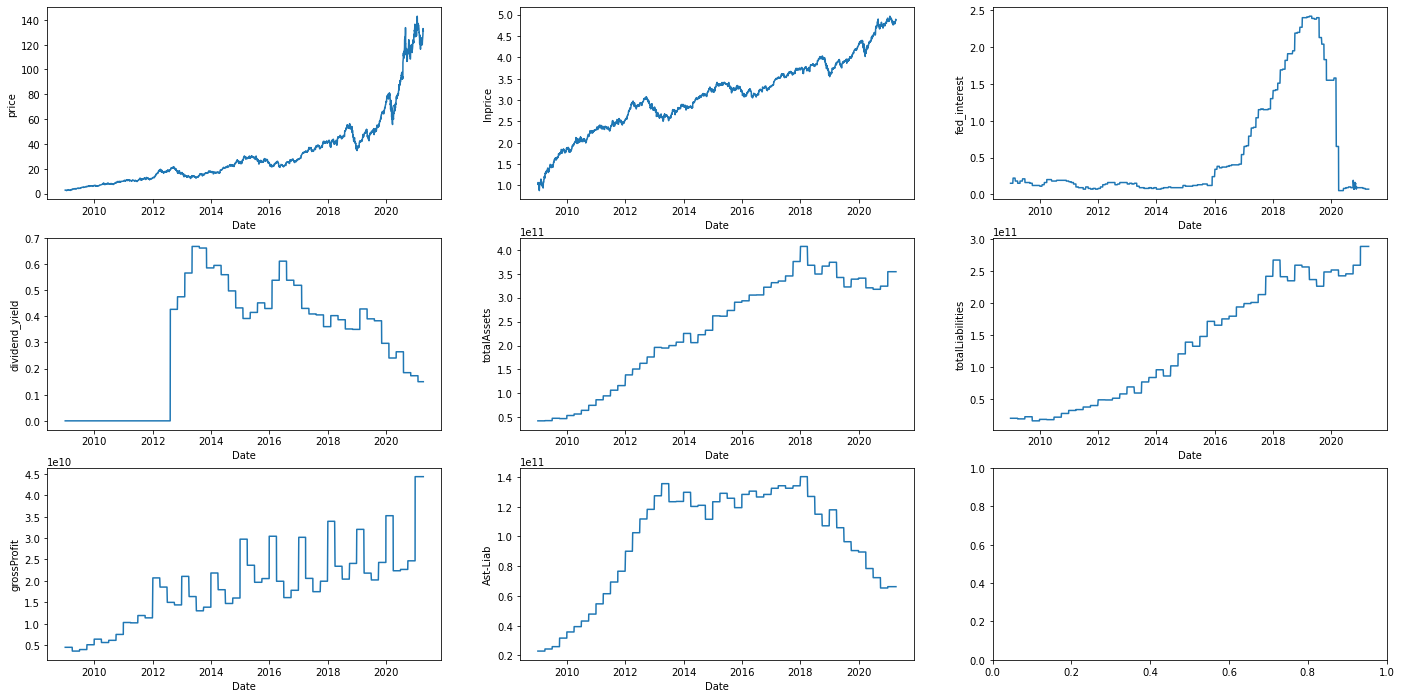

In [17]:
f, axes = plt.subplots(3, 3, figsize=(24, 12))
sb.lineplot(data = merged, x='Date', y='price', ax=axes[0,0])
sb.lineplot(data = merged, x='Date', y='lnprice', ax=axes[0,1])
sb.lineplot(data = merged, x='Date', y='fed_interest', ax=axes[0,2])
sb.lineplot(data = merged, x='Date', y='dividend_yield', ax=axes[1,0])
sb.lineplot(data = merged, x='Date', y='totalAssets', ax=axes[1,1])
sb.lineplot(data = merged, x='Date', y='totalLiabilities', ax=axes[1,2])
sb.lineplot(data = merged, x='Date', y='grossProfit', ax=axes[2,0])
sb.lineplot(data = merged, x='Date', y='Ast-Liab', ax=axes[2,1])

<AxesSubplot:>

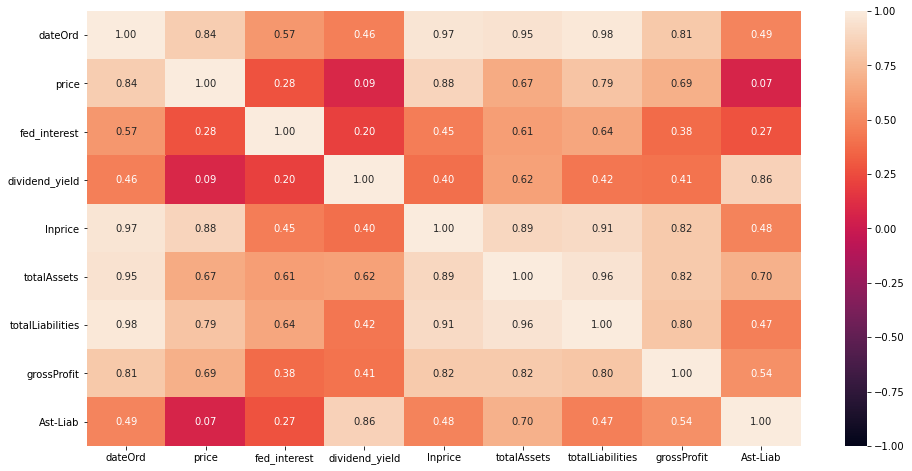

In [18]:
f = plt.figure(figsize=(16, 8))
sb.heatmap(merged.corr(), vmin = -1, vmax = 1, annot = True, fmt=".2f")

In [ ]:
#pairplot code here i forgot what it was lol

In [19]:
merged_rolling = merged
merged_rolling['rolling_price1'] = merged_rolling.rolling(window = 20)['price'].mean() # s
merged_rolling['rolling_price2'] = merged_rolling.rolling(window = 100)['price'].mean()
merged_rolling.drop(['dateOrd', 'fed_interest', 'Date', 'dividend_yield', 'lnprice', 'totalAssets', 'totalLiabilities', 'grossProfit', 'Ast-Liab'],1, inplace = True)

In [20]:
merged_rolling_new = merged_rolling.iloc[100:600] # edit this when time frame changes, left number = longer timeframe, right number = data size + left number
merged_rolling_new

,price,rolling_price1,rolling_price2
Date_Ordinal,,,
737742,119.081500,119.830377,126.795151
737741,119.031574,119.670617,126.655517
737740,119.311155,119.483397,126.545028
737739,115.796424,119.193332,126.423993
737738,116.145900,118.790935,126.323352
...,...,...,...
737025,42.481527,41.011959,42.455036
737024,42.574174,41.224684,42.372753
737021,42.006096,41.535054,42.292012


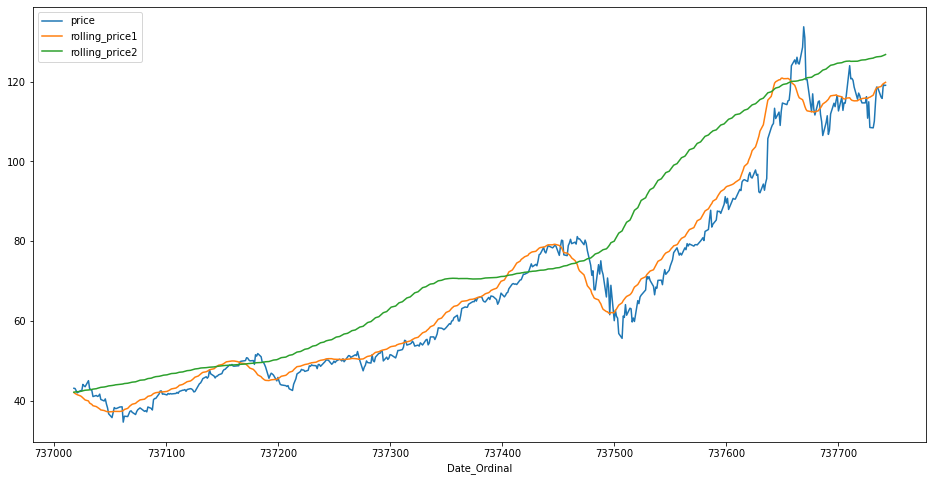

In [21]:
lines = merged_rolling_new.plot.line(figsize=(16,8))